In [1]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver, MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

In [4]:
class VQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        def objective(x):
            job = self._estimator.run([self._circuit], [operators], [x])
            estimator_result = job.result()
            value = estimator_result.values[0]
            if self._callback is not None:
                self._callback(value)
            return value
            
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        res = self._optimizer.minimize(objective, x0=x0)
        

        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

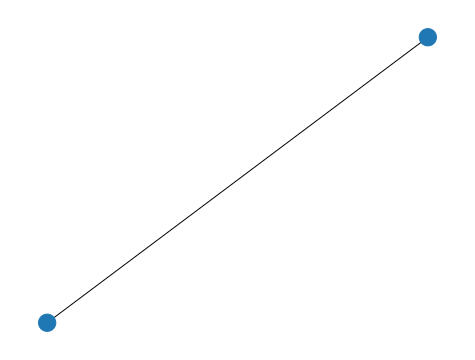

In [5]:
num_sites = 2
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [6]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZ', 'YY', 'XX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [9]:
hamiltonian.eval().primitive.data

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  2.+0.j,  0.+0.j],
       [ 0.+0.j,  2.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [14]:
print(hamiltonian.eval().primitive.data.astype(int))

[[ 1  0  0  0]
 [ 0 -1  2  0]
 [ 0  2 -1  0]
 [ 0  0  0  1]]


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_26194/1530903205.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(hamiltonian.eval().primitive.data.astype(int))


In [15]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [17]:
print(bmatrix(hamiltonian.eval().primitive.data.astype(int)))

\begin{bmatrix}
  1 & 0 & 0 & 0\\
  0 & -1 & 2 & 0\\
  0 & 2 & -1 & 0\\
  0 & 0 & 0 & 1\\
\end{bmatrix}


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_26194/2407667632.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(bmatrix(hamiltonian.eval().primitive.data.astype(int)))


In [18]:
for jawn in hamiltonian.eval().primitive.data.astype(int):
    print("{", ",".join(map(str, jawn)), "},")

{ 1,0,0,0 },
{ 0,-1,2,0 },
{ 0,2,-1,0 },
{ 0,0,0,1 },


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_26194/4023989667.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  for jawn in hamiltonian.eval().primitive.data.astype(int):


In [13]:
exact_solver = ClassicalEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)

print(exact_result.eigenvalues[0])
exact_result.eigenstates[0].primitive.draw("latex")

# gs_energy = np.round(exact_result.eigenvalues[0], 4)

-3.0


<IPython.core.display.Latex object>